In [29]:
import datetime

import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.models import load_model, Sequential
from keras.backend import clear_session
from keras.layers import Dense, Rescaling
from keras.optimizers import gradient_descent_v2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard, EarlyStopping
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [30]:
# tf.config.threading.set_intra_op_parallelism_threads(10)
# tf.config.threading.set_inter_op_parallelism_threads(10)

tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
mnist_training_data = pd.read_csv("data/train.csv")

X: pd.DataFrame = mnist_training_data.drop('label', axis=1)
y: pd.DataFrame = mnist_training_data.label

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

In [33]:
X_train.shape

(26880, 784)

In [34]:
clear_session()

In [7]:
model = Sequential([
    Rescaling(1. / 255, input_shape=[784]),
    Dense(500, activation="relu"),
    Dense(300, activation="relu"),
    Dense(100, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])


2022-03-12 19:49:45.169282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 19:49:45.169735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:49:45.169845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-12 19:49:45.169891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [42]:
def build_model(learning_rate=3e-3) -> Sequential:
    model = Sequential()

    model.add(Rescaling(1. / 255, input_shape=[784]))

    model.add(Dense(300, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    optimizer = gradient_descent_v2.SGD(learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


keras_clf = KerasClassifier(build_fn=build_model)

/tmp/ipykernel_49304/4171295700.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_clf = KerasClassifier(build_fn=build_model)


In [41]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)

In [10]:
# history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),
#                     callbacks=[tensorboard_callback, early_stopping_callback])

In [43]:
param_distribs = {
    # "n_hidden": [2, 3, 5],
    # "n_neurons": [200, 300, 400],
    "learning_rate": [0.003, 0.03, 0.3]
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val),
                  callbacks=[early_stopping_callback, tensorboard_callback])

Epoch 1/200


/home/asgrim/.cache/pypoetry/virtualenvs/ml-learning-b6VmGrsv-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


560/560 [==============================] - 1s 1ms/step - loss: 1.7523 - accuracy: 0.5426 - val_loss: 1.2145 - val_accuracy: 0.7673
Epoch 2/200
560/560 [==============================] - 1s 1ms/step - loss: 0.9000 - accuracy: 0.8135 - val_loss: 0.7026 - val_accuracy: 0.8376
Epoch 3/200
560/560 [==============================] - 1s 1ms/step - loss: 0.5986 - accuracy: 0.8575 - val_loss: 0.5360 - val_accuracy: 0.8634
Epoch 4/200
560/560 [==============================] - 1s 1ms/step - loss: 0.4851 - accuracy: 0.8726 - val_loss: 0.4594 - val_accuracy: 0.8774
Epoch 5/200
560/560 [==============================] - 1s 2ms/step - loss: 0.4261 - accuracy: 0.8856 - val_loss: 0.4153 - val_accuracy: 0.8848
Epoch 6/200
560/560 [==============================] - 1s 1ms/step - loss: 0.3893 - accuracy: 0.8949 - val_loss: 0.3859 - val_accuracy: 0.8936
Epoch 7/200
560/560 [==============================] - 1s 1ms/step - loss: 0.3635 - accuracy: 0.9007 - val_loss: 0.3662 - val_accuracy: 0.8960
Epoch 8/200

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fd08e6620b0>,
                   param_distributions={'learning_rate': [0.003, 0.03, 0.3]})

In [42]:
# tensorboard --logdir other/kaggle/mnist/logs

In [44]:
rnd_search_cv.best_score_, rnd_search_cv.best_params_

(0.972284217675527, {'learning_rate': 0.3})

In [45]:
rnd_search_cv.score(X_test, y_test)

263/263 [==============================] - 0s 971us/step - loss: 0.0995 - accuracy: 0.9740


0.9740476012229919

In [48]:
# model.evaluate(X_test, y_test)

263/263 [==============================] - 0s 596us/step - loss: 0.1003 - accuracy: 0.9724


[0.100255087018013, 0.9723809361457825]

In [46]:
rnd_search_cv.best_estimator_.model.save('mnist_kaggle_model_rnd.h5')

In [15]:
model.save("mnist_kaggle_model_rnd.h5")

AttributeError: 'KerasClassifier' object has no attribute 'save'

In [47]:
# loaded_model = load_model("mnist_kaggle_model.h5")
loaded_model = load_model("mnist_kaggle_model_rnd.h5")
loaded_model.evaluate(X_test, y_test)

263/263 [==============================] - 0s 932us/step - loss: 0.0995 - accuracy: 0.9740


[0.09946855902671814, 0.9740476012229919]

In [51]:
assert model.evaluate(X_test, y_test) == loaded_model.evaluate(X_test, y_test)

263/263 [==============================] - 0s 462us/step - loss: 0.1003 - accuracy: 0.9724


#### Predict data with trained model

In [48]:
X: pd.DataFrame = pd.read_csv("data/test.csv")

In [49]:
mnist_model: Sequential = load_model("mnist_kaggle_model_rnd.h5")
predictions = mnist_model.predict(X)

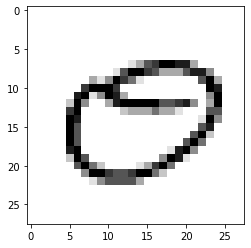

Predicted value is: 0


In [54]:
random_idx = np.random.randint(0, len(predictions))
random_idx = 59
example_image = X.iloc[random_idx].to_numpy()
example_image = example_image.reshape(28, 28)

plt.imshow(example_image, cmap="binary")
plt.show()
print("Predicted value is:", np.argmax(predictions[random_idx]))

In [51]:
data = {'ImageId': np.arange(1, len(predictions) + 1), 'Label': np.argmax(predictions, axis=1)}
results_df = pd.DataFrame(data=data).to_csv("results.csv", index=False)